## Obligatorio de Deep Learning - Semestre 2 - 2022

## 1. Setup

### 1.1 Imports

In [42]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import os
if os.path.exists("/content/drive/MyDrive/ORT/DeepLearning/Obligatorio"):
  os.chdir('/content/drive/MyDrive/ORT/DeepLearning/Obligatorio')
else:
  os.chdir("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio")


In [44]:
!ls

 data
'Deep Learning - Obligatorio 2022.pdf'
 kaggle_test_output.csv
 outputs
 __pycache__
 Referencias.gdoc
'Template HDFS Log Classification.ipynb'
 utils.py


In [45]:
import numpy as np
import datetime as dt
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Embedding, LSTM, Dense, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from importlib import reload
import utils
utils = reload(utils)

### 1.2 Set random seeds

In [46]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

In [47]:
hdfs_train, hdfs_test_kaggle = utils.read_data()

In [48]:
hdfs_train[:4]

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal


In [49]:
hdfs_test_kaggle[:5]

,id,sequence
0,0,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25)"
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,..."
2,2,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."
3,3,"(4, 4, 4, 21, 10, 8, 10, 8, 25, 25, 25, 10, 8,..."
4,4,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."


## 3. Análisis exploratorio de datos

### 3.1 Análisis descriptivo general: Distribuciones, Scatterplots, Barplots...

In [50]:
hdfs_train.head()

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
4,4,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal


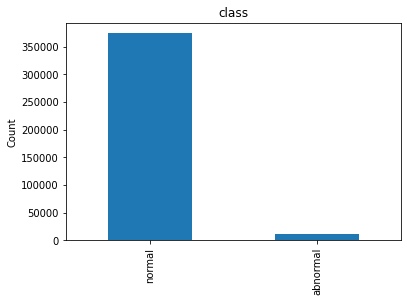

In [51]:
utils.value_counts(hdfs_train,'class')

### 3.2 Análisis de secuencias

In [52]:
#Agregar ploteo de largos de secuencias, distribuciones por simbolo, etc.

In [53]:
raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train, one_hot=True)
#raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
try:
    data_y.value_counts()
except:
    pass

In [55]:
min([min(s) for s in raw_sequences])

1

In [56]:
max([max(s) for s in raw_sequences])

28

In [57]:
max([len(s) for s in raw_sequences])

298

###Hiperarámetros

In [58]:
vocab_size = 30#max([max(s) for s in raw_sequences]) + 1
max_len = 19
batch_size = 15
epochs = 8
patience = 10

#### Haremos padding de valor 0 a las secuencias para estandarizar el largo

In [59]:
padded_sequences = utils.pad_sequences(raw_sequences, max_len)

## 4. Entrenamiento de Language Model

### 4.1. Data preprocessing
#### 4.1.1 Particionamiento

In [60]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.split(padded_sequences, data_y)

#### 4.1.2 X_train_aug (para data augmentation)

In [61]:
X_train_for_aug, _, _, _, _, _ = utils.split(raw_sequences, data_y)


In [62]:
try:
  X_train_aug, y_train_aug = utils.sequences_augmentation(X_train_for_aug, y_train, max_len)
except:
  pass

### Grid Search

### Model Mejorado 

In [63]:
optimizer = Adam() #para agregar clip value clipvalue=0.5
loss = 'categorical_crossentropy'
embedding_size = 3#math.ceil(vocab_size**0.25) #es un hiperparametro. cuanto mas grande, mayor el entrenamiento

#### Entrenamiento

In [64]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_10 (LSTM)              (None, 19, 64)            17408     
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,655
Trainable params: 50,655
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#se agregó class.weights
training, model = utils.train(model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/8
 2313/17338 [===>..........................] - ETA: 5:54 - loss: 0.1985 - accuracy: 0.9579

#### Evaluation

In [ ]:
utils.eval_model(training, model, X_test, y_test)

### Modelo Mejorado con Batch Normalization

In [ ]:
modelBN = Sequential()
modelBN.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelBN.add(LSTM(64, return_sequences=True))
modelBN.add(LSTM(64, return_sequences=False))
modelBN.add(BatchNormalization())
modelBN.add(Dense(2, activation='softmax'))
modelBN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
modelBN.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingBN, modelBN = utils.train(modelBN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluation

In [ ]:
utils.eval_model(trainingBN, modelBN, X_test, y_test)

### Modelo Mejorado con Gradient Clipping

In [ ]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [ ]:
modelGC = Sequential()
modelGC.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelGC.add(LSTM(64, return_sequences=True))
modelGC.add(LSTM(64, return_sequences=False))
modelGC.add(Dense(2, activation='softmax'))
modelGC.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
modelGC.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGC, modelGC = utils.train(modelGC,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluation

In [ ]:
utils.eval_model(trainingGC, modelGC, X_test, y_test)

### Modelo Mejorado con Batch Normalization y Gradient Clipping

In [ ]:
modelGC_BN = Sequential()
modelGC_BN.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelGC_BN.add(LSTM(64, return_sequences=True))
modelGC_BN.add(LSTM(64, return_sequences=False))
modelGC_BN.add(BatchNormalization())
modelGC_BN.add(Dense(2, activation='softmax'))
modelGC_BN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
modelGC_BN.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGC_BN, modelGC_BN = utils.train(modelGC_BN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluation

In [ ]:
utils.eval_model(trainingGC_BN, modelGC_BN, X_test, y_test)

## 5 Generación de salida para competencia Kaggle

In [ ]:
vocab_size = 30#max([max(s) for s in raw_sequences]) + 1
max_len = 19
batch_size = 15
epochs = 8
patience = 10

In [ ]:
for x in [modelGC_BN,modelGC, modelBN, model]:
  #generate kaggle
  utils.load_test_sequences_and_generate_prediction_file(x, hdfs_test_kaggle, max_len, f'{x=}'.partition('=')[0]+'_maxLen'+max_len+'_batchSize'+batch_size+'_epochs'+epochs )

  # serialize model to JSON
  model_json = model.to_json()
  with open("outputs/model_"+f'{x=}'.partition('=')[0]+'_maxLen'+max_len+'_batchSize'+batch_size+'_epochs'+epochs+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
    json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("outputs/model_Weigths"+f'{x=}'.partition('=')[0]+'_maxLen'+max_len+'_batchSize'+batch_size+'_epochs'+epochs+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
  print("Saved model to disk")

## 6 Consigna

### A) Participación en Competencia Kaggle:
El objetivo de este punto es participar en la competencia de Kaggle y obtener como mínimo un Macro Average Recall (o Weighted Accuracy) superior al 80%. [->Link a la competencia<-](https://www.kaggle.com/t/6d15e3a96bd049b2b4b2a491a69a0fc7).

### B) Utilización de Grid Search (o equivalente):
Para cumplir con la busqueda de modelos óptimos se debe realizar un grid search lo más abarcativo y metódico posible.

### C) Se debe a su vez investigar e implementar al menos 2 de las siguientes técnicas:
#### 1. [Batch Normalization](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
#### 2. [Data Augmentation a través de la realización de Windowing](https://blog.finxter.com/how-to-loop-through-a-python-list-in-batches/#Method_1_Iterating_over_Consecutive_Sliding_Windows)
#### 3. [Gradient Normalization y/o Gradient Clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/)
